In [1]:
from typing import List, Dict, Tuple

import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

__WORKING_BRANCH_PATH = (
    "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch"
)

hatch = {
    'Vector': '',
    'Skiplist': '\\\\\\\\\\\\',
    'Hashskiplist': '//',
    'Hashlinklist': '----'
}

linestyle = {
    'Vector': '-',
    'Skiplist': '--',
    'Hashskiplist': ':',
    'Hashlinklist': '-.'
}

alpha = {
    'Vector': 1,
    'Skiplist': 0.8,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

color = {
    'Vector': 'darkslateblue',
    'Skiplist': 'slategray',
    'Hashskiplist': 'darkkhaki',
    'Hashlinklist': 'chocolate'
    # 'Vector': 'black',
    # 'Skiplist': 'black',
    # 'Hashskiplist': 'black',
    # 'Hashlinklist': 'black'
}

linewidth = {
    'Vector': 1,
    'Skiplist': 1,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

edgecolor = {
    'Vector': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black'
}

label = {
    'Vector': 'vector',
    'Skiplist': 'skiplist',
    'Hashskiplist': 'hash skiplist',
    'Hashlinklist': 'hash linklist'
}

plt.rcParams["font.family"] = "serif"

alphabets = "abcdefghijklmnopqrstuvwxyz"

In [2]:
def get_properties(key: str) -> Dict[str, str]:
    if key.capitalize() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": color.get(key.capitalize()) or "None",
            # "edgecolor": edgecolor.get(key.capitalize()) or "None",
            # "linestyle": linestyle.get(key.capitalize()),
            # "hatch": hatch.get(key.capitalize()),
            "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")

In [3]:
def get_exp_dirname(query_type: str, selectivity: float, entry_size: int) -> str:
    return (
        f"{__WORKING_BRANCH_PATH}/experiments-{query_type}-{selectivity}-{entry_size}"
    )


def get_log_file_path(
    query_type: str,
    inserts: int,
    point_queries: int,
    range_queries: int,
    selectivity: float,
    memtable: str,
    entry_size: int,
    number_of_entries_per_page: int,
    number_of_pages: int,
    prefixlen: int = 0,
    bucket_count: int = 0,
    size_ratio: int = 4,
    updates: int = 0,
):
    if memtable.lower() in ("hashskiplist", "hashlinklist"):
        return f"{get_exp_dirname(query_type, selectivity, entry_size)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio} l {prefixlen} bucket_count {bucket_count}"
    return f"{get_exp_dirname(query_type, selectivity, entry_size)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio}"

In [4]:
def prepare_dataframe(log_file_path: str, key: str="RangeQueryTime: ") -> pd.DataFrame:
    ff = open(log_file_path, "r")
    range_quereis = []

    for line in ff.readlines():
        if key in line:
            range_quereis.append(float(line.split(" ")[1]))
    
    return pd.DataFrame(range_quereis, columns=["TimeTaken"])


In [5]:
selectivities = [0.0001, 0.02, 0.4, 0.8] # [0.0001, 0.02, 0.06, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8]
prefix_lengths = [2, 4, 6, 8, 10]
bucket_counts = [65536]  # [100, 1000, 5000, 10000, 25000, 65536, 100000]

query_type = "MOTIVATION"
entry_size = 64
memtables = ["Vector", "Skiplist", "HashSkiplist", "HashLinklist"]
inserts = 140000
point_queries = 200
range_queries = 200
number_of_entries_per_page = 64
number_of_pages = 4096
updates = 0

In [6]:
def plot_one_cell(ax, i, j, selectivity, prefixlen, bucket_count, fig):
    vec_log_file_path = get_log_file_path(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[0],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    skip_log_file_path = get_log_file_path(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[1],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    hash_skip_log_file_path = get_log_file_path(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[2],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    hash_link_log_file_path = get_log_file_path(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[3],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    vec_df = prepare_dataframe(vec_log_file_path+"/workload.log", "RangeQueryTime: ")
    skip_df = prepare_dataframe(skip_log_file_path+"/workload.log", "RangeQueryTime: ")
    hash_skip_df = prepare_dataframe(hash_skip_log_file_path+"/workload.log", "RangeQueryTime: ")
    hash_link_df = prepare_dataframe(hash_link_log_file_path+"/workload.log", "RangeQueryTime: ")

    ax[i, j].plot(
        vec_df.index,
        vec_df["TimeTaken"]/1000,
        label="vector",
        **get_properties("Vector"),
    )

    ax[i, j].plot(
        skip_df.index,
        skip_df["TimeTaken"]/1000,
        label="skip list",
        **get_properties("Skiplist"),
    )

    ax[i, j].plot(
        hash_skip_df.index,
        hash_skip_df["TimeTaken"]/1000,
        label="hash skip list",
        **get_properties("Hashskiplist"),
    )

    ax[i, j].plot(
        hash_link_df.index,
        hash_link_df["TimeTaken"]/1000,
        label="hash link list",
        **get_properties("Hashlinklist"),
    )

    if i == 0 and j == 0:
        fig.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, 0.05),
            ncol=4,
            fontsize=12,
            frameon=False,
        )

def plot_one_row(ax, i, prefixlen, bucket_count, fig):
    
    for selectivity in selectivities:
        plot_one_cell(ax, i, selectivities.index(selectivity), selectivity, prefixlen, bucket_count, fig)


FileNotFoundError: [Errno 2] No such file or directory: '/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-MOTIVATION-0.0001-64/I 140000 U 0 S 200 Y 0.0001 Q 200 m vector E 64 B 64 P 4096 T 4/workload.log'

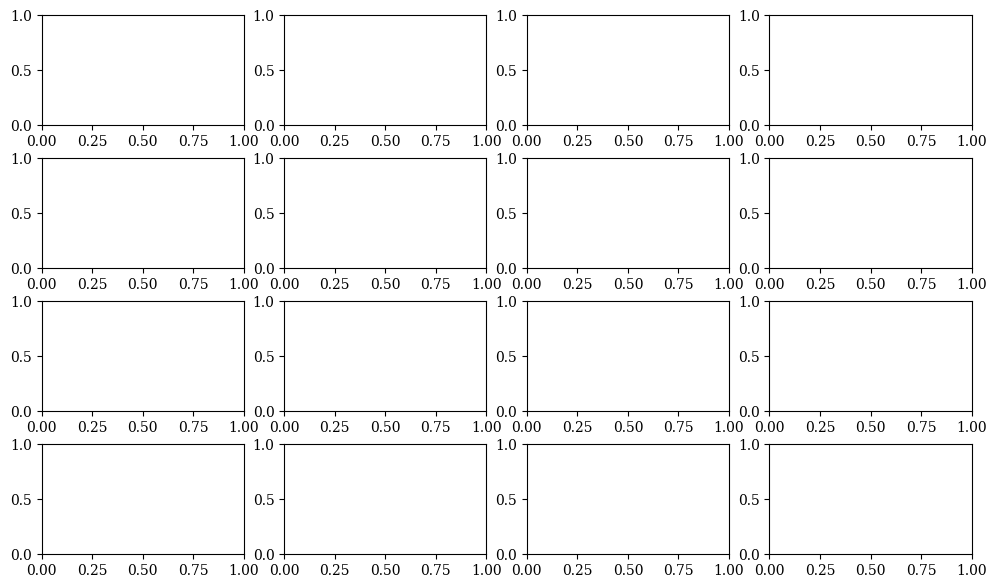

In [7]:
import matplotlib.gridspec as gridspec


plot_for = (
    (2, 65536),
    (6, 65536),

    (2, 100000),   # (prefixlen, bucket_count)
    # (4, 100000),
    (6, 100000),
    # (8, 100000),
    # (4, 65536),
    # (8, 65536),
)

fig, ax = plt.subplots(len(plot_for), len(selectivities), figsize=(12, 7), gridspec_kw={"hspace": 0.3, "wspace": 0.2})
gs = gridspec.GridSpec(4, 3, figure=fig)

for i, pf in enumerate(plot_for):
    prefixlen, bucket_count = pf

    plot_one_row(ax, i, prefixlen, bucket_count, fig)

    for j in range(len(selectivities)):
        ax[i, j].set_ylim(bottom=0)

    if i == 0:
        for j in range(len(selectivities)):
            ax[i, j].set_title(f"Selectivity {selectivities[j]}", fontsize=12)
        # fig.tight_layout()

    if i == len(plot_for)-1:
        for j in range(len(selectivities)):
            ax[i, j].set_xlabel("range queries", fontsize=12)
        
    ax[i, 0].set_ylabel(f"X {prefixlen}, H {bucket_count}\nlatency (ms)", fontsize=12)
plt.savefig("range-queries.eps", format="eps", bbox_inches="tight", dpi=1200)